# Project 2

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

ReLU activation function

In [3]:
def relu(x):
    return jnp.maximum(0.0, x)

Sigmoid activation function

In [4]:
def sigmoid(x):
    return 1 / (1 + jnp.exp(-x))

Flexible neural network architecture with initial random weights and biases

In [5]:
in_dim = 1
out_dim = 1
hidden_dims = [2]          
num_layers = len(hidden_dims) + 1

weights = []
biases = []

class NeuralNetwork:
    def __init__(self, in_dim, out_dim, hidden_dims, key, init_type="standard"):
        """
        init_type: "standard" for N(0, 1) or "xavier" for Xavier/Glorot weighting
        """
        self.layer_dims = [in_dim] + hidden_dims + [out_dim]
        self.num_layers = len(self.layer_dims) - 1
        self.init_type = init_type # Store the initialization choice

        self.params = self.init_params(key)

    def init_params(self, key):
        params = []
        keys = jax.random.split(key, self.num_layers)

        for i in range(self.num_layers):
            k = keys[i]
            n_in = self.layer_dims[i]
            n_out = self.layer_dims[i + 1]
            
            # Draw from standard normal distribution N(0, 1)
            W = jax.random.normal(k, (n_in, n_out))
            
            # Apply weighting based on choice 
            if self.init_type == "xavier":
                stddev = jnp.sqrt(2.0 / (n_in + n_out))
                W = W * stddev
            # If init_type is "standard", W remains N(0, 1)
            
            b = jnp.zeros((n_out,))
            params.append((W, b))

        return params


def forward(params, x, activation):
    h = x
    for i, (W, b) in enumerate(params):
        z = h @ W + b
        if i < len(params) - 1:
            h = activation(z)
        else:
            h = z
    return h


MSE Loss

In [6]:
def mse_loss(params,  x, y_true, activation):
    y_pred = forward(params, x, activation)
    return jnp.mean((y_pred - y_true) ** 2)


Training step using automatic differentation from JAX

In [7]:
from functools import partial

@partial(jax.jit,  static_argnames=("activation",))
def train_step(params, x, y, lr, activation):
    loss, grads = jax.value_and_grad(mse_loss)(params, x, y, activation)

    new_params = [
        (W - lr * dW, b - lr * db)
        for (W, b), (dW, db) in zip(params, grads)
    ]

    return new_params, loss

Simplest initial example, $ y = Ax + b$.

In [8]:
# Dimensions
num_samples = 10

# Input data
x = jnp.linspace(0, 1, num_samples).reshape(-1, in_dim)

# Random ground-truth linear model
key = jax.random.PRNGKey(42)
key_A, key_b = jax.random.split(key)

A_true = jax.random.normal(key_A, (in_dim, out_dim))
b_true = jax.random.normal(key_b, (out_dim,))

# Generate targets
y = x @ A_true + b_true

print(y)


[[0.60576403]
 [0.6142002 ]
 [0.6226364 ]
 [0.6310725 ]
 [0.6395087 ]
 [0.64794487]
 [0.6563811 ]
 [0.6648172 ]
 [0.6732534 ]
 [0.68168956]]


Initialise and train network

In [9]:
lr = 1e-1
model = NeuralNetwork(in_dim, out_dim, hidden_dims, key)
params = model.params
activation = relu

losses = []

for epoch in range(2000):
    params, loss = train_step(params, x, y, lr, activation)

    losses.append(loss)

    if epoch % 100 == 0:
        print(f"epoch {epoch}, loss: {loss:.12f}")

epoch 0, loss: 0.385397374630
epoch 100, loss: 0.000082268067
epoch 200, loss: 0.000031653235
epoch 300, loss: 0.000012800811
epoch 400, loss: 0.000005217569
epoch 500, loss: 0.000002131869
epoch 600, loss: 0.000000872130
epoch 700, loss: 0.000000357049
epoch 800, loss: 0.000000146241
epoch 900, loss: 0.000000059920
epoch 1000, loss: 0.000000024555
epoch 1100, loss: 0.000000010062
epoch 1200, loss: 0.000000004128
epoch 1300, loss: 0.000000001692
epoch 1400, loss: 0.000000000694
epoch 1500, loss: 0.000000000284
epoch 1600, loss: 0.000000000116
epoch 1700, loss: 0.000000000048
epoch 1800, loss: 0.000000000020
epoch 1900, loss: 0.000000000008


In [10]:
y_pred = forward(params, x, activation)
print("Predictions:", y_pred)
print("True targets:", y)

Predictions: [[0.605766  ]
 [0.61419713]
 [0.622634  ]
 [0.63107085]
 [0.6395077 ]
 [0.64794457]
 [0.6563814 ]
 [0.6648183 ]
 [0.6732552 ]
 [0.68169206]]
True targets: [[0.60576403]
 [0.6142002 ]
 [0.6226364 ]
 [0.6310725 ]
 [0.6395087 ]
 [0.64794487]
 [0.6563811 ]
 [0.6648172 ]
 [0.6732534 ]
 [0.68168956]]


Final prediction

## Data Acquisition
In accordance with the project suggestions, we use the `scikit-learn` library to retrieve the MNIST dataset. This dataset contains 70,000 grayscale images of handwritten digits (0-9), each of size $28 \times 28$ pixels.

In [11]:
from sklearn.datasets import fetch_openml
import numpy as np

# Fetching the MNIST dataset (784 features correspond to 28x28 flattened pixels)
print("Loading MNIST dataset...")
mnist = fetch_openml("mnist_784", version=1, as_frame=False) 

# X contains the flattened vector representations of the images
# y contains the corresponding labels (0-9)
X, y = mnist["data"], mnist["target"].astype(np.uint8) 

print(f"Dataset loaded: {X.shape[0]} samples with {X.shape[1]} features.")

Loading MNIST dataset...
Dataset loaded: 70000 samples with 784 features.


## Data Visualization
To better understand the dataset we are working with, the following cell implements a function to visualize individual MNIST images from their flattened vector representations.

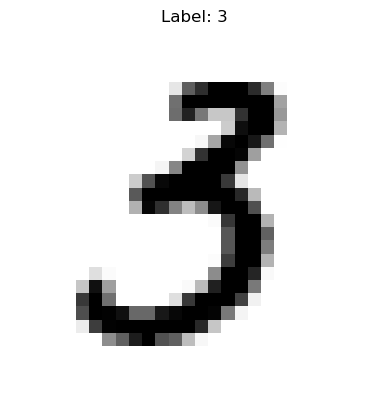

In [13]:
import matplotlib.pyplot as plt

def plot_digit(data, label):
    """
    Visualizes a single MNIST digit.
    Reshapes the 784 flattened vector back to a 28x28 image.
    """
    image = data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.title(f"Label: {label}")
    plt.axis("off")
    plt.show()

# Example: visualizing the first image of the dataset
plot_digit(X[789], y[789])

## 2.a. Training of the neural network with cross-entropy loss and mini-batch gradient descent.

#### Softmax
To handle the multiclass classification of MNIST digits, we implement the **Softmax** function to transform the network's raw outputs into probability distributions. 

In [14]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    # Subtraction of max improves numerical stability
    e_x = jnp.exp(x - jnp.max(x, axis=-1, keepdims=True))
    return e_x / jnp.sum(e_x, axis=-1, keepdims=True)

#### One-Hot Encoding
Since the MNIST labels are integers from 0 to 9, we need to transform them into binary vectors of size 10. This **one-hot encoding** allows the network to compare its 10-way output probabilities with the ground truth during the loss calculation.

In [15]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

#### Loss Function 
We then define the **Categorical Cross-Entropy Loss**, which is the standard objective function for such tasks.

In [16]:
def cross_entropy_loss(params, x, y_true, activation):
    """Multiclass Cross-Entropy Loss."""
    # Forward pass through the network
    logits = forward(params, x, activation)
    
    # Apply softmax to get probabilities
    probs = softmax(logits)
    
    # Compute cross-entropy: -sum(y_true * log(probs))
    # We add a small epsilon (1e-9) to avoid log(0)
    return -jnp.mean(jnp.sum(y_true * jnp.log(probs + 1e-9), axis=-1))

#### Accuracy Metric
While the loss function is used for optimization, **accuracy** provides a human-readable performance metric. It calculates the percentage of images correctly classified by comparing the index of the highest predicted probability with the true label.

In [17]:
def accuracy(params, x, y_true, activation):
    """Computes the accuracy of the model."""
    logits = forward(params, x, activation)
    predictions = jnp.argmax(logits, axis=-1)
    return jnp.mean(predictions == y_true)

#### Data Normalization
The raw pixel values in `X` range from 0 to 255. To ensure numerical stability and prevent gradients from vanishing or exploding during the training of our `NeuralNetwork`, we scale these values to the range $[0, 1]$ by dividing by 255.

In [27]:
# Normalizing the feature matrix
X_normalized = X / 255.0

print(f"Original range: {X.min()} to {X.max()}")
print(f"Normalized range: {X_normalized.min()} to {X_normalized.max()}")

Original range: 0 to 255
Normalized range: 0.0 to 1.0


#### Train-Test Split
We split our dataset into a training set (to optimize the parameters) and a testing set (to evaluate final performance). We use 80% of the data for training and 20% for testing. We also convert these arrays into `jax.numpy` arrays to leverage JAX's computational speed.

In [34]:
from sklearn.model_selection import train_test_split

# 1. Splitting into 80% train/validation pool and 20% final test
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_normalized, y, test_size=0.2, random_state=42
)

# 2. Converting to JAX arrays 
# Note: We use the suffix '_full' to indicate this is the complete training pool 
# that the K-Fold will later split into training and validation folds.
X_train_full = jnp.array(X_train_raw)
X_test = jnp.array(X_test_raw)
y_train_full = jnp.array(y_train_raw)
y_test = jnp.array(y_test_raw)

print(f"Training pool (X_train_full): {X_train_full.shape[0]} images")
print(f"Final test set (X_test): {X_test.shape[0]} images")

Training pool (X_train_full): 56000 images
Final test set (X_test): 14000 images


#### k-fold cross-validation
As requested in the project instructions, we implement a **k-fold cross-validation** ($k=5$) combined with a **grid search** to select the best hyperparameters. This approach ensures that our model's performance is not dependent on a specific train-validation split.

In [35]:
from sklearn.model_selection import KFold

# Defining K=5 folds as suggested in the instructions
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

print(f"Setup complete for {num_folds}-fold cross-validation.")

Setup complete for 5-fold cross-validation.


## 2.b. Hyperparameters
We define the grid of hyperparameters to explore, including hidden layer architectures, learning rates, and batch sizes, as specified in the assignment[cite: 31, 32].

In [36]:
# Hyperparameters to vary (Question 2a)
param_grid = {
    'learning_rates': [0.1, 0.01],
    'architectures': [[128], [128, 64]],
    'batch_sizes': [32, 64],
    'epochs': [10] # Number of epochs for each fold
}

#### Training Step for Classification
We update our training step to handle the multiclass classification task. Unlike the previous version used for regression, this function utilizes the **Categorical Cross-Entropy Loss**. It is decorated with `@jax.jit` to compile the function for faster execution and uses `jax.value_and_grad` to automatically compute the gradients of the loss with respect to the network parameters.

In [37]:
@partial(jax.jit, static_argnames=("activation",))
def train_step_classification(params, x_batch, y_batch, lr, activation):
    # Calcul de la perte et des gradients sur le batch actuel
    loss, grads = jax.value_and_grad(cross_entropy_loss)(params, x_batch, y_batch, activation)
    
    # Mise à jour des paramètres (SGD)
    new_params = [
        (W - lr * dW, b - lr * db)
        for (W, b), (dW, db) in zip(params, grads)
    ]
    return new_params, loss

#### Mini-batch Gradient Descent Implementation
To follow the project requirements, we implement a training loop that processes data in mini-batches. This approach provides a balance between the stability of full-batch gradient descent and the efficiency of stochastic gradient descent. We also include a shuffling mechanism at each epoch to ensure the model does not learn the order of the data.

In [38]:
def train_model_batches(X_train, y_train, config, key):
    """
    Trains the network using mini-batch gradient descent.
    """
    # 1. Initialization
    model = NeuralNetwork(
        in_dim=784, 
        out_dim=10, 
        hidden_dims=config['architecture'], 
        key=key, 
        init_type=config['init_type']
    )
    params = model.params
    y_train_oh = one_hot(y_train, 10) # Format labels for Cross-Entropy
    
    num_samples = X_train.shape[0]
    batch_size = config['batch_size']
    num_batches = num_samples // batch_size
    
    # Track losses for the learning curves requested in Question 2a
    epoch_losses = []

    for epoch in range(config['epochs']):
        # Shuffle data at the start of each epoch
        key, subkey = jax.random.split(key)
        perm = jax.random.permutation(subkey, num_samples)
        X_shuffled = X_train[perm]
        y_shuffled_oh = y_train_oh[perm]
        
        total_loss = 0
        for i in range(num_batches):
            start = i * batch_size
            end = start + batch_size
            
            # Update parameters using only the current batch
            params, loss = train_step_classification(
                params, 
                X_shuffled[start:end], 
                y_shuffled_oh[start:end], 
                config['lr'], 
                config['activation']
            )
            total_loss += loss
            
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        
    return params, epoch_losses

#### Hyperparameter Optimization Strategy
To comply with the requirement of selecting "promising hyperparameters", we implement a nested loop. The outer loop iterates through our **Grid Search** configurations (architecture, learning rate, batch size), while the inner loop performs a **5-fold Cross-Validation**. This process ensures that the reported accuracy is an average across different data splits, providing a reliable measure of the model's generalization capability.

In [43]:
import itertools
import numpy as np

# 1. Define the hyperparameter grid as specified in the project 
param_grid = {
    'architecture': [[128], [128, 64]],
    'lr': [0.1, 0.01],
    'batch_size': [32, 64],
    'epochs': [10],
    'activation': [relu],
    'init_type': ["xavier"]
}

# Generate all unique combinations from the grid
keys, values = zip(*param_grid.items())
grid_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_config = None
best_avg_acc = -1.0
best_params = None
results_log = []

print(f"Starting Grid Search: {len(grid_combinations)} combinations x {num_folds} folds.\n")

# 2. Outer Loop: Iterate through each hyperparameter configuration 
for config in grid_combinations:
    fold_accuracies = []
    print(f"Testing Config: Arch={config['architecture']}, LR={config['lr']}, Batch={config['batch_size']}")
    
    # 3. Inner Loop: Perform K-Fold Cross-Validation (K=5) 
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
        # Split the training pool into training and validation folds for this iteration
        X_fold_train, X_fold_val = X_train_full[train_idx], X_train_full[val_idx]
        y_fold_train, y_fold_val = y_train_full[train_idx], y_train_full[val_idx]
        
        # Train the model using the mini-batch gradient descent function [cite: 30]
        key = jax.random.PRNGKey(fold) 
        params, _ = train_model_batches(X_fold_train, y_fold_train, config, key)
        
        # Evaluate performance on the validation fold
        val_acc = accuracy(params, X_fold_val, y_fold_val, config['activation'])
        fold_accuracies.append(val_acc)
    
    # Calculate the average accuracy across all 5 folds for this configuration
    avg_acc = np.mean(fold_accuracies)
    results_log.append({'config': config, 'avg_acc': avg_acc})
    print(f"  -> Average Val Accuracy: {avg_acc:.4f}\n")
    
    # Save the best configuration and parameters found so far
    if avg_acc > best_avg_acc:
        best_avg_acc = avg_acc
        best_config = config
        best_params = params # Prevents 'best_params not defined' error later

print("--- Grid Search Complete ---")
print(f"Best Config found: {best_config}")
print(f"Best Validation Accuracy: {best_avg_acc:.4f}")

Starting Grid Search: 8 combinations x 5 folds.

Testing Config: Arch=[128], LR=0.1, Batch=32
  -> Average Val Accuracy: 0.9747

Testing Config: Arch=[128], LR=0.1, Batch=64
  -> Average Val Accuracy: 0.9705

Testing Config: Arch=[128], LR=0.01, Batch=32
  -> Average Val Accuracy: 0.9428

Testing Config: Arch=[128], LR=0.01, Batch=64
  -> Average Val Accuracy: 0.9268

Testing Config: Arch=[128, 64], LR=0.1, Batch=32
  -> Average Val Accuracy: 0.9758

Testing Config: Arch=[128, 64], LR=0.1, Batch=64
  -> Average Val Accuracy: 0.9737

Testing Config: Arch=[128, 64], LR=0.01, Batch=32
  -> Average Val Accuracy: 0.9571

Testing Config: Arch=[128, 64], LR=0.01, Batch=64
  -> Average Val Accuracy: 0.9410

--- Grid Search Complete ---
Best Config found: {'architecture': [128, 64], 'lr': 0.1, 'batch_size': 32, 'epochs': 10, 'activation': <function relu at 0x15b31a700>, 'init_type': 'xavier'}
Best Validation Accuracy: 0.9758


### 2.c. Analysis of Misclassified Images
After training our best model, we evaluate it on the test set to identify images where the prediction does not match the true label. Visualizing these errors helps us understand if the mistakes are due to ambiguous handwriting or inherent limitations of our dense network architecture.

In [44]:
# 1. Get predictions on the test set
test_logits = forward(best_params, X_test, relu) # Use your best activation
test_predictions = jnp.argmax(test_logits, axis=-1)

# 2. Find indices where predictions differ from true labels
# Note: y_test is already jnp.array from our split step
misclassified_indices = jnp.where(test_predictions != y_test)[0]

print(f"Number of misclassified images: {len(misclassified_indices)} out of {len(y_test)}")

Number of misclassified images: 354 out of 14000


#### Visualization of Misclassified Images (Question 2c)
To analyze the model's performance, we identify instances in the test set where the predicted label differs from the ground truth. Visualizing these 10 examples allows us to discuss possible reasons for failure, such as ambiguous handwriting or the limitations of flattened vector representations.

Total misclassified in test set: 354 / 14000


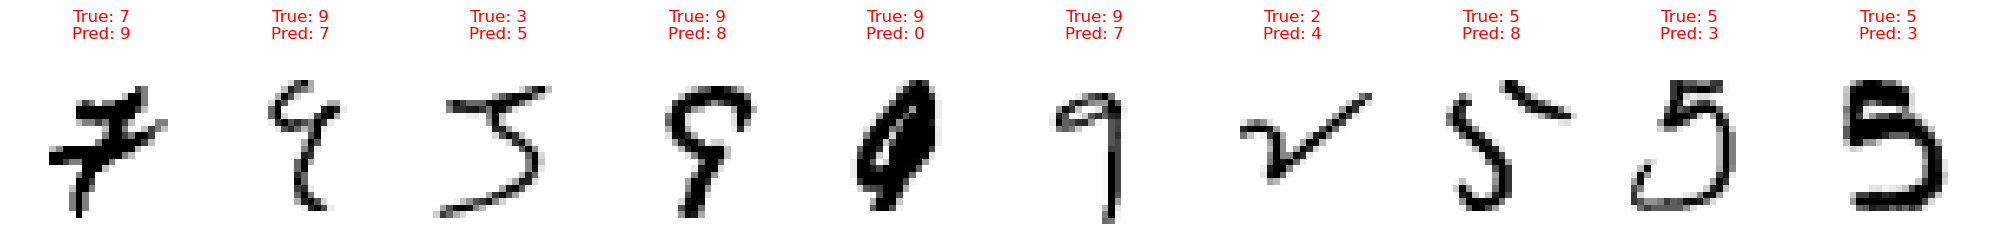

In [45]:
import matplotlib.pyplot as plt

# 1. Generate predictions for the entire test set using the best parameters
# We use the activation function defined in our best_config
test_logits = forward(best_params, X_test, best_config['activation'])
test_predictions = jnp.argmax(test_logits, axis=-1)

# 2. Identify indices where the prediction is incorrect
# y_test contains the true labels (0-9)
misclassified_indices = jnp.where(test_predictions != y_test)[0]

print(f"Total misclassified in test set: {len(misclassified_indices)} / {len(y_test)}")

# 3. Plot 10 misclassified images
num_to_show = 10
plt.figure(figsize=(20, 4))

for i in range(num_to_show):
    idx = misclassified_indices[i]
    image = X_test[idx].reshape(28, 28)
    true_label = y_test[idx]
    pred_label = test_predictions[idx]
    
    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(image, cmap='binary')
    plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()